In [4]:
##############

import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
import itertools
import os

###############

np.set_printoptions(suppress=True)
os.chdir("../data")  # moves working directory to data folder

In [5]:
npath = ''
cpath = '/Users/Clara Escanuela/Downloads/'

path = cpath

def optim_bins(mult_arry):
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    print(energy_res)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event)
        weights.append(weight)
        i += 1
    
    return weights

def root_input(path, filename):
    rTree = uproot.open(path + filename)
    
    rTree_event = rTree['event_tree']
    rTree_data = rTree['data_tree']
    
    event_x_pos = np.array(rTree_event['event_x_pos'])
    event_E = np.array(rTree_event['event_E'])

    data_event = np.array(rTree_data['data_event'])
    #data_pmt = np.array(rTree_data['data_pmt'])
    data_time = np.array(rTree_data['data_time']) 

    data_index, count_scint = np.unique(data_event, return_counts=True)
    #split_pmt = np.split(data_pmt, np.cumsum(count_scint)) 
    split_time = np.split(data_time, np.cumsum(count_scint))

    return split_time, count_scint, event_x_pos, event_E

def pairwise(iterable):
    "s -> (s0,s1), (s2,s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

fname_sigdel = 'events_solar_delayed.root'
fname_sig = 'events_solar_prompt.root'
fname_bkg = 'events_alphagamma_200000_foils.root'
fname_Ar36 = 'events_neutrons_36Ar_100000_foils.root'
fname_Ar40 = 'events_neutrons_40Ar_100000_foils.root'
fname_Rn = 'events_Rn222_100000_foils.root'

sig_split_time, sig_scint, sig_x, sig_event_E = root_input(path, fname_sig) 
sig_split_timedel, sig_scintdel, sig_xdel, sig_event_Edel = root_input(path, fname_sigdel) 
bkg_split_time, bkg_scint, bkg_x, bkg_event_E = root_input(path, fname_bkg)  
Ar36_split_time, Ar36_scint, Ar36_x, Ar36_event_E = root_input(path, fname_Ar36)  
Ar40_split_time, Ar40_scint, Ar40_x, Ar40_event_E = root_input(path, fname_Ar40)  
Rn_split_time, Rn_scint, Rn_x, Rn_event_E = root_input(path, fname_Rn)  
sig_event_E = sig_event_E + 1.64

#########################

bkg_split_time_temp = []
bkg_split_E_temp = []
for x, y in pairwise(bkg_split_time):
    bkg_split_time_temp.append(np.append(x,y))
    
bkg_split_time = bkg_split_time_temp
    
for x,y in pairwise(bkg_event_E):
    bkg_split_E_temp.append(np.append(x,y))
    
bkg_split_E = bkg_split_E_temp

sig_split_time_temp = []
sig_split_E_temp = []
for x, y in pairwise(sig_split_timedel):
    sig_split_time_temp.append(np.append(x,y))
    
sig_split_timedel = sig_split_time_temp
    
for x,y in pairwise(sig_event_Edel):
    sig_split_E_temp.append(x+y)
    
sig_event_Edel = sig_split_E_temp

outputtime = np.hstack((sig_split_timedel[0:40000], sig_split_time[0:60000]))
outputE = np.hstack((sig_event_Edel[0:40000], sig_event_E[0:60000]))
sig_split_time = outputtime
sig_event_E = outputE

C:\Users\Clara Escanuela\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


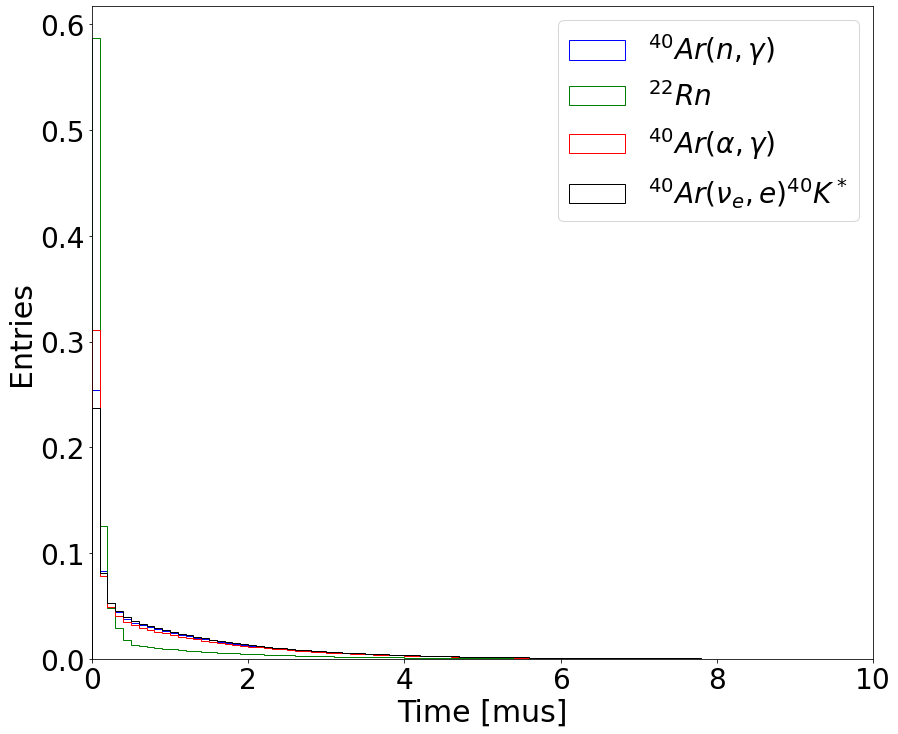

In [6]:
# Plot time distribution

data = [np.concatenate(sig_split_time), np.concatenate(bkg_split_time), np.concatenate(Rn_split_time), np.concatenate(Ar40_split_time)]
rates = [1, 1, 1, 1] # normalise

labels = [r'$^{40}Ar(\nu_e, e)^{40}{K}^*$', r'${}^{40} Ar(\alpha, \gamma)$', r'${}^{22} Rn$', r'${}^{40} Ar(n, \gamma)$']
colors = ['black', 'red', 'green', 'blue']

# Plot time distribution

num_bins = 200


plt.figure(figsize=(14,12))

n, bins, patches = plt.hist(data, stacked = False, color=colors, bins=int(10/0.1), range=[0, 10], label=labels, histtype='step', weights=hist_weights(rates, data))

plt.xlabel('Time [mus]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Entries',fontsize=30)
plt.yticks(fontsize=28)
plt.xlim(0, 10)
#plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

0.0028514254845266617


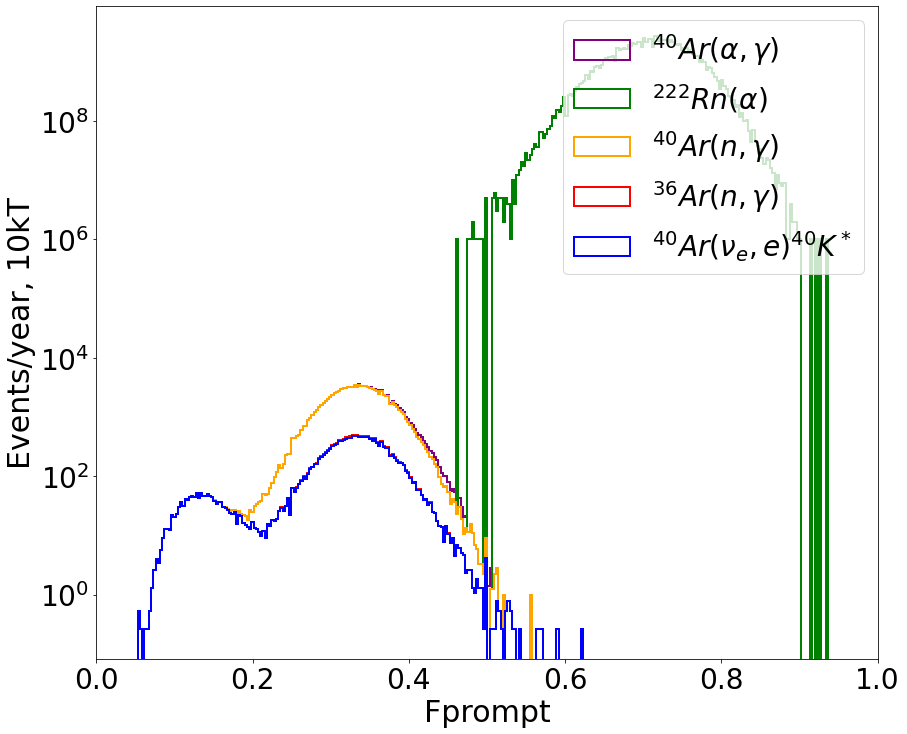

In [7]:
#Fprompt

def Fprompt(split_time, time):

    fprompt = np.array([])

    for event in split_time:
        if event.size > 0:
            fprompt = np.append(fprompt, len(event[event <= time*0.001])/len(event))
            
    return fprompt

#####################

max_time = 200

Fprompt_B8 = Fprompt(sig_split_time, max_time)
Fprompt_Ar36 = Fprompt(Ar36_split_time, max_time)
Fprompt_Ar40 = Fprompt(Ar40_split_time, max_time)
Fprompt_Rn = Fprompt(Rn_split_time, max_time)
Fprompt_AG = Fprompt(bkg_split_time, max_time)


rates = [26700*0.64, 10**8*0.006*(1/10**3), 10**8*0.994*(1/10**3), 10**(11), 3000] # normalise

data = [Fprompt_B8, Fprompt_Ar36, Fprompt_Ar40, Fprompt_Rn, Fprompt_AG]

labels = [r'${}^{40} Ar(\nu_e, e){}^{40} K^*$', r'${}^{36} Ar(n, \gamma)$', r'${}^{40} Ar(n, \gamma)$', r'${}^{222} Rn(\alpha)$', r'${}^{40} Ar(\alpha, \gamma)$']
colors = ['blue', 'red', 'orange', 'green', 'purple']

plt.figure(figsize=(14,12))

num_bins = optim_bins(data)

n_, bins_, patches_ = plt.hist(data, stacked = True, color=colors, bins=num_bins, label=labels, histtype='step', weights=hist_weights(rates, data), linewidth=2)

plt.xlabel('Fprompt',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Events/year, 10kT',fontsize=30)
plt.yticks(fontsize=28)
plt.xlim([0, 1])
plt.yscale('log')

plt.legend(fontsize=28)

#plt.savefig('../figures/fprompt_all_xe.png', bbox_inches='tight')

plt.show()

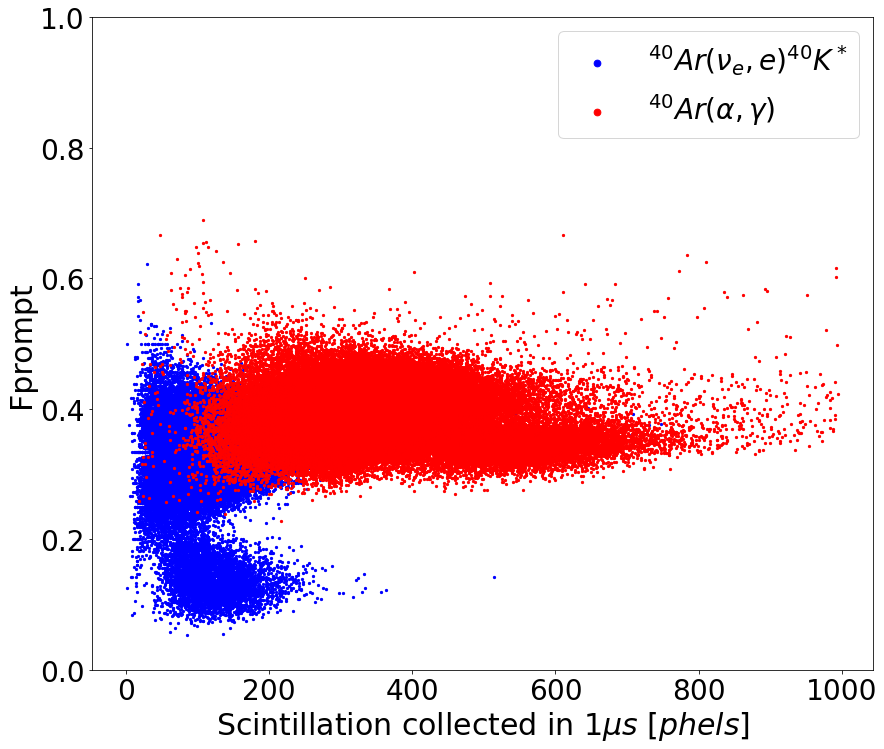

In [8]:
#########################

def scint_timewindow(split_time, set_time):
    #time is in microseconds
    i = 0
    scint_output = np.array([])

    for time in split_time:
        mask = (time <= set_time)
    
        if time.size > 0:
            scint_output = np.append(scint_output, len(time[mask])) # number of photons detected in time window
        i += 1
    
    return scint_output


t_window = 1

signl_wind = scint_timewindow(sig_split_time, t_window)
bkg_wind = scint_timewindow(bkg_split_time, t_window)

#########################

plt.figure(figsize=(14,12))

sig_label = r'$^{40}Ar(\nu_e, e)^{40}{K}^*$'
bkg_label = r'${}^{40} Ar(\alpha, \gamma)$'

num_mask = 2000
scint_mask = 1000
plt.scatter(signl_wind[signl_wind < scint_mask], Fprompt_B8[signl_wind < scint_mask], s = 20, label=sig_label, marker='.', color='blue')

plt.scatter(bkg_wind[bkg_wind < scint_mask], Fprompt_AG[bkg_wind < scint_mask], s = 20, label=bkg_label, marker='.', color='red')
#plt.axhline(y=0.2, color='black', linestyle='dashed', linewidth=0.7)

plt.ylabel('Fprompt', fontsize=30)
plt.xlabel(r'Scintillation collected in $1 \mu s$ [$phels$]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(markerscale=3, fontsize=28)
plt.ylim(0,1)

plt.show()

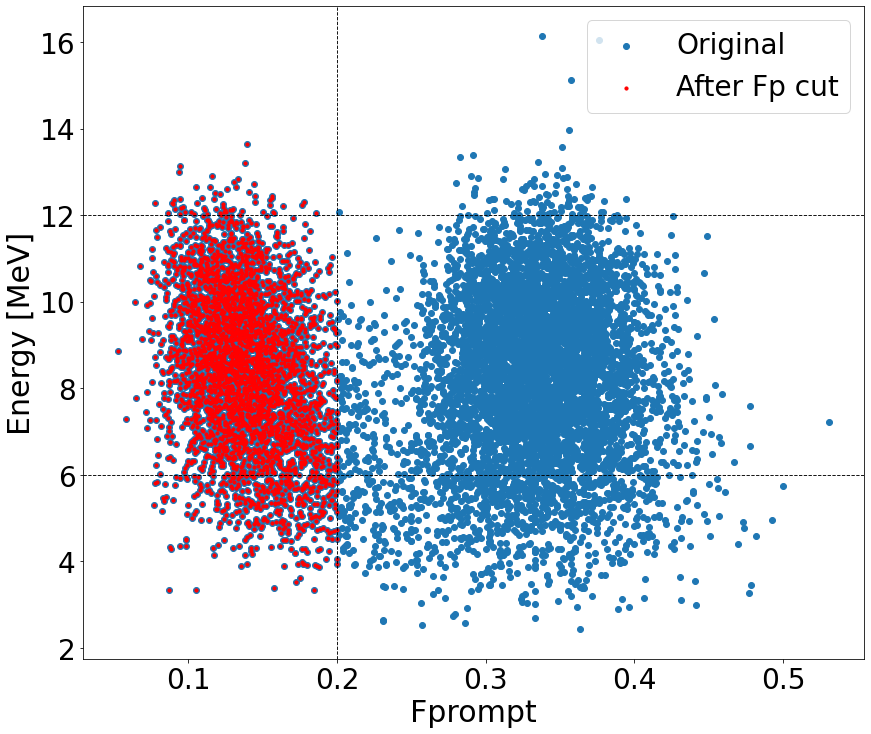

In [72]:
plt.figure(figsize=(14,12))

plt.scatter(Fprompt_B8, sig_event_E, label='Original')
plt.scatter(Fprompt_B8[Fprompt_B8<=0.2], sig_event_E[Fprompt_B8<=0.2], color='red', s=10, label='After Fp cut')

plt.xlabel('Fprompt',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Energy [MeV]',fontsize=30)
plt.yticks(fontsize=28)
plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
plt.axhline(y=12, linestyle = "dashed", color="black", linewidth = 0.9)
plt.axhline(y=6, linestyle = "dashed", color="black", linewidth = 0.9)
#plt.xlim(0, 10)

plt.legend(fontsize=28)

plt.show()

0.25762854219797166


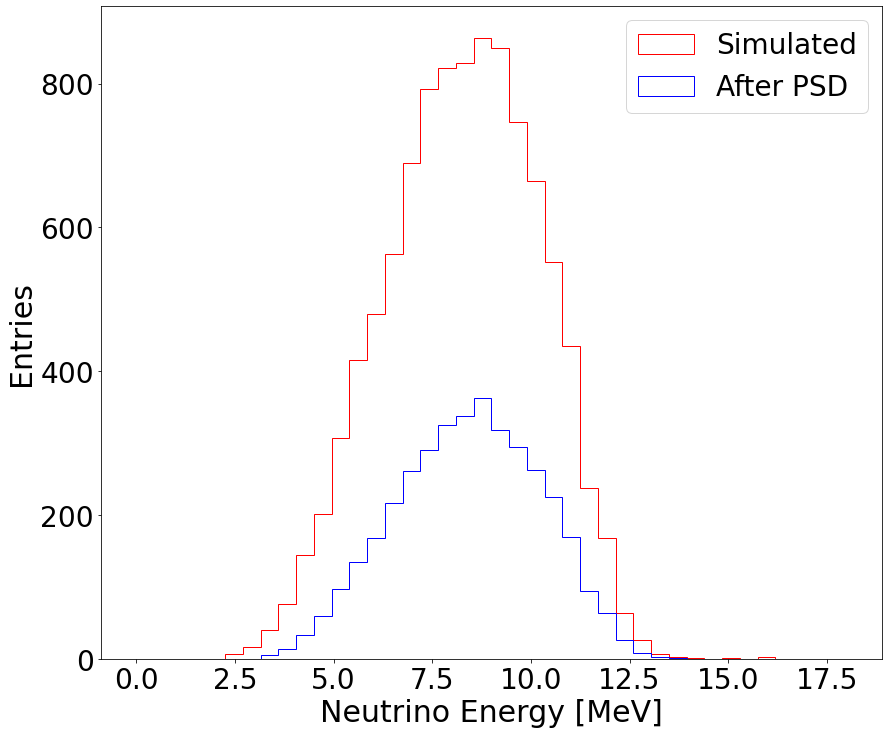

In [75]:
plt.figure(figsize=(14,12))

num_bins = optim_bins([sig_event_E])

rates = [26700*0.64]

num_bins=40

n_before, bins_before, patches_before = plt.hist(sig_event_E ,stacked = False, bins=num_bins, label='Simulated', range=(0,18), histtype='step', color='red')
n_after, bins_after, patches_after = plt.hist(sig_event_E[Fprompt_B8<=0.2] ,stacked = False, bins=num_bins, range=(0, 18), label='After PSD', histtype='step', color='blue')

plt.xlabel('Neutrino Energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Entries',fontsize=30)
plt.yticks(fontsize=28)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
#plt.xlim(0, 10)

plt.legend(fontsize=28)

plt.savefig('../figures/enerdist_psd.png', bbox_inches='tight')

plt.show()

[0.         0.         0.         0.         0.         0.
 0.         0.125      0.17105263 0.22916667 0.29353234 0.31596091
 0.32289157 0.35073069 0.38543517 0.37880987 0.36569987 0.39537713
 0.40772014 0.42013889 0.3745583  0.39544236 0.39398496 0.4076087
 0.3908046  0.39662447 0.38095238 0.40625    0.30769231 0.28571429
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
0.32602696349413696
0.10902731425687634


C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_1864/491718388.py:8: RuntimeWarning: invalid value encountered in double_scalars
  efficiency = n_after[i]/n_before[i]
C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_1864/491718388.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  std = np.sqrt((1/nb**2)*((na)*(1-na/nb)))
C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_1864/491718388.py:17: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt((1/nb**2)*((na)*(1-na/nb)))
C:\Users\Clara Escanuela\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

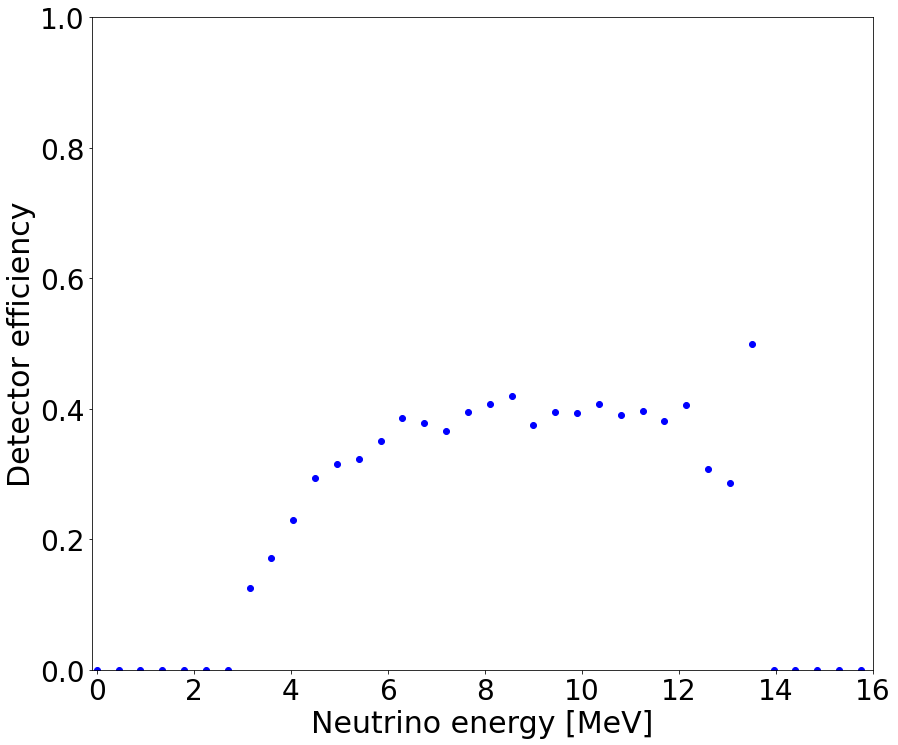

In [74]:
eff_ener = np.array([])
err_eff=np.array([])
energy = np.linspace(0, 18, num_bins)

bin_width = bins_before[0] - bins_before[1]

for i in range(0, num_bins):
    efficiency = n_after[i]/n_before[i]
    eff_ener = np.append(eff_ener, efficiency)
    
def std_bay(na, nb):
    #Bayesian statistics
    return np.sqrt(((na+1)*(na+2))/((nb+2)*(nb+3))-(na+1)**2/(nb+2)**2)

def errors_bin(na, nb):
    #Binomial errors
    std = np.sqrt((1/nb**2)*((na)*(1-na/nb)))
    return std

for i in range(0, num_bins):
    err_eff = np.append(err_eff, (errors_bin(n_after[i], n_before[i])))

eff_ener[np.isnan(eff_ener)] = 0 
err_eff[np.isnan(err_eff)] = 0 

def sigmoid(x, a, b, c, d, e):
    return a/(d + np.exp(-b*x+c))+e

plt.figure(figsize=(14,12))

popt, pcov = curve_fit(sigmoid, bins_before[0:num_bins-1], eff_ener[0:num_bins-1])

print(eff_ener)

print(np.mean(eff_ener[6:num_bins-14]))
print(np.std(eff_ener[6:num_bins-14]))

#plt.plot(bins_before[0:num_bins],sigmoid(bins_before[0:num_bins], *popt), color='blue')
#plt.errorbar(bins_before[0:num_bins], sigmoid(bins_before[0:num_bins], *popt), yerr=err_eff, fmt='o', color='blue', markersize=5, capsize=5)
plt.scatter(bins_before[0:num_bins-1], eff_ener[0:num_bins-1], color='blue')

plt.xlim(-0.1, 16)
plt.ylim(0, 1)

plt.ylabel('Detector efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)
#plt.yscale('log')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
#plt.legend(fontsize=28)